In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
firewall_04062012 = pd.read_csv('Firewall/Firewall-04062012.csv',low_memory=False)
firewall_04072012 = pd.read_csv('Firewall/Firewall-04072012.csv',low_memory=False)

# Data Wrangling for Visualization 1

In [3]:
# combine two datasets into one
combined_data = pd.concat([firewall_04062012, firewall_04072012], ignore_index=True)

# filter only denied operations
filtered_combined = combined_data[combined_data['Operation'].isin(['Deny','Deny by ACL'])]

# Count the occurrences of each source port, sort them, and take the top 10
top_10_source_ports = filtered_combined['Source port'].value_counts().sort_values(ascending=False).head(10)

# Create a list of the top 10 source ports (the index of the Series)
top_10_list = top_10_source_ports.index.tolist()

# filter out rows with source port in the list
filtered_top10 = filtered_combined[filtered_combined['Source port'].isin(top_10_list)]

# Count occurrences of each 'Source port' value, grouped by 'unique source port'
filtered_top10_count = filtered_top10.groupby('Source port').size().reset_index(name='count_source_port')

# Visualization 1

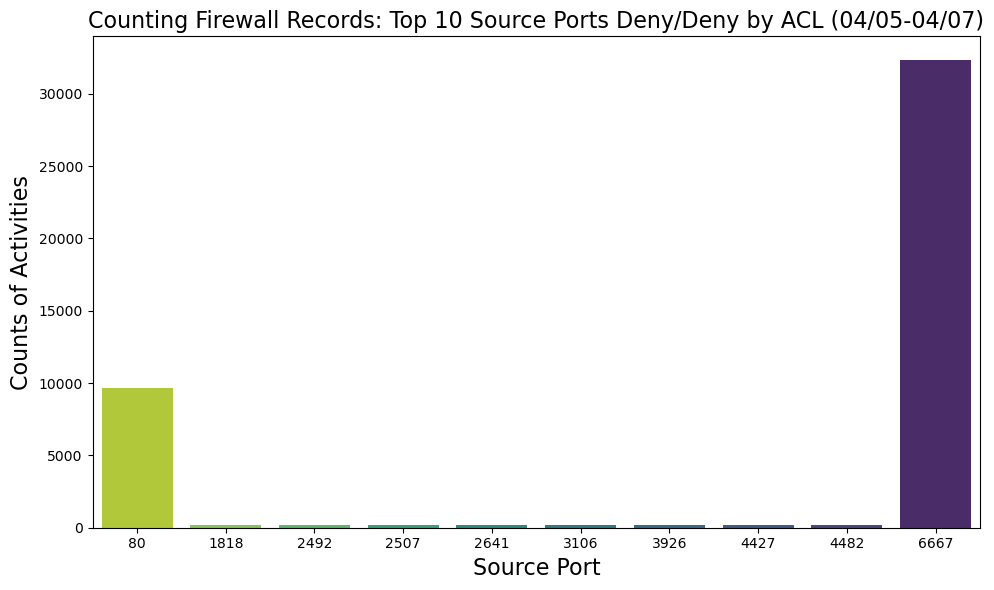

In [4]:
# bar plot for top 10 denied source port 04/05-04/07

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_top10_count, x=pd.to_numeric(filtered_top10_count['Source port']), y='count_source_port', palette= 'viridis_r')

# Customizing the plot
plt.title("Counting Firewall Records: Top 10 Source Ports Deny/Deny by ACL (04/05-04/07)", fontsize=16)
plt.xlabel("Source Port", fontsize=16)
plt.ylabel("Counts of Activities", fontsize=16)
plt.tight_layout()

# Display the plot
plt.show()

# Data Wrangling for Visualization 2

In [5]:
# Find unique Source port values in each dataset
unique_in_data1 = set(firewall_04062012['Source port']).difference(firewall_04072012['Source port'])
unique_in_data2 = set(firewall_04072012['Source port']).difference(firewall_04062012['Source port'])

# Create the 'unique source port' column for each dataset
firewall_04062012['unique source port'] = firewall_04062012['Source port'].apply(lambda x: 'unique in log1' if x in unique_in_data1 else 'not unique')
firewall_04072012['unique source port'] = firewall_04072012['Source port'].apply(lambda x: 'unique in log2' if x in unique_in_data2 else 'not unique')

# Concatenate the two datasets
combined_data = pd.concat([firewall_04062012, firewall_04072012], ignore_index=True)

In [6]:
# Filter out 'unique in log1' and 'unique in log2' rows
filtered_combined = combined_data[combined_data['unique source port'].isin(['unique in log1', 'unique in log2'])]

# Count the occurrences of each source port, sort them, and take the top 10
top_10_source_ports = filtered_combined['Source port'].value_counts().sort_values(ascending=False).head(10)

# Create a list of the top 10 source ports (the index of the Series)
top_10_list = top_10_source_ports.index.tolist()

# filter out rows with source port in the list
filtered_top10 = filtered_combined[filtered_combined['Source port'].isin(top_10_list)]

# Count occurrences of each 'Source port' value, grouped by 'unique source port'
source_port_counts = filtered_top10.groupby(['Source port', 'unique source port']).size().reset_index(name='count_source_port')

# Visualization 2

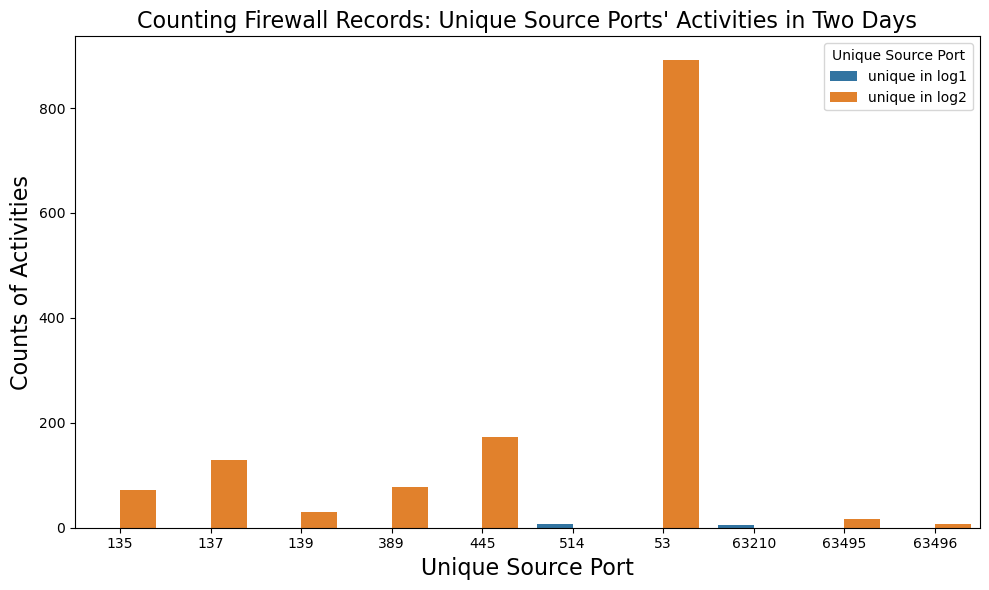

In [7]:
# Define the desired order for the legend
hue_order = ['unique in log1', 'unique in log2']  # Reversed order

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=source_port_counts, x='Source port', y='count_source_port', hue='unique source port', hue_order=hue_order)

# Customizing the plot
plt.title("Counting Firewall Records: Unique Source Ports' Activities in Two Days", fontsize=16)
plt.xlabel("Unique Source Port", fontsize=16)
plt.ylabel("Counts of Activities", fontsize=16)
plt.legend(title = "Unique Source Port")
plt.tight_layout()

# Display the plot
plt.show()

# Data Wrangling for Visualization 3

In [8]:
# Convert time to timestamp
firewall_04062012['Date/time'] = pd.to_datetime(firewall_04062012['Date/time'], format='%d/%b/%Y %H:%M:%S')
firewall_04062012.set_index('Date/time', inplace=True)

In [9]:
# Convert time to timestamp
firewall_04072012['Date/time'] = pd.to_datetime(firewall_04072012['Date/time'], format='%d/%b/%Y %H:%M:%S')
firewall_04072012.set_index('Date/time', inplace=True)

In [10]:
# Combine Dataset
firewall_all = pd.concat([firewall_04062012,firewall_04072012])

In [11]:
stacked_activity_trend_all = firewall_all.groupby([firewall_all.index, 'Operation']).size().unstack(fill_value=0)
stacked_activity_trend_all = stacked_activity_trend_all.resample('5Min').sum()

# Visualization 3

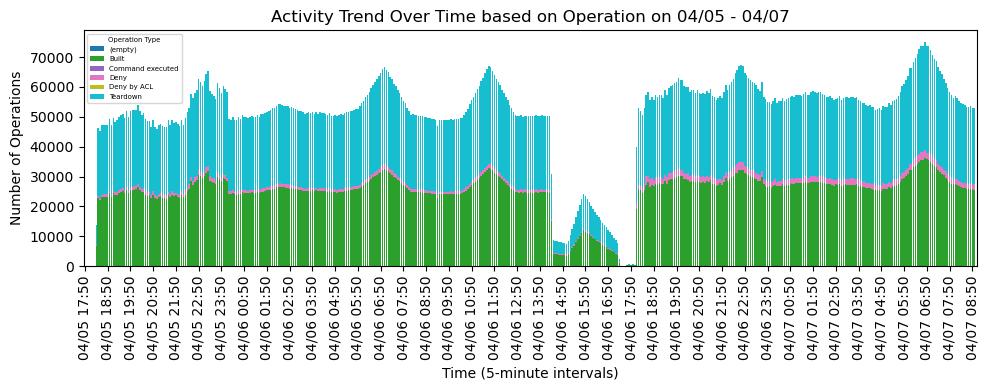

In [12]:
ax = stacked_activity_trend_all.plot(kind='bar', stacked=True, colormap='tab10', width=0.8, figsize=(10, 4))

plt.title('Activity Trend Over Time based on Operation on 04/05 - 04/07')
plt.xlabel('Time (5-minute intervals)')
plt.ylabel('Number of Operations')

ax.set_xticks(range(0, len(stacked_activity_trend_all), 12))  # Set ticks to every 60 minutes (6 * 10 min)
ax.set_xticklabels(stacked_activity_trend_all.index[::12].strftime('%m/%d %H:%M'), rotation=90)  # Format the tick labels

plt.legend(loc='upper left',fontsize='5', title='Operation Type', title_fontsize='5')
plt.tight_layout()
plt.show()

# Data Wrangling for Visualization 4

In [13]:
# Function to filter activity of a source ip and visualize its activity
def filter_ip_and_visualize_activity(source_port):
    filtered_df = firewall_all[firewall_all['Source port'] == source_port]
    filtered_activity_trend = filtered_df.groupby([filtered_df.index, 'Operation']).size().unstack(fill_value=0)
    filtered_activity_trend = filtered_activity_trend.resample('5Min').sum()
    
    ax = filtered_activity_trend.plot(kind='bar', stacked=True, colormap='tab10', width=0.8, figsize=(10, 4))

    # Adding labels and title
    plt.title(source_port + "'s Activity Trend Over Time based on Operation on 04/05 - 04/07")
    plt.xlabel('Time (5-minute intervals)')
    plt.ylabel('Number of Operations')
    plt.ylim(0, 220)

    ax.set_xticks(range(0, len(filtered_activity_trend), 12))  # Set ticks to every 60 minutes (6 * 10 min)
    ax.set_xticklabels(filtered_activity_trend.index[::12].strftime('%m/%d %H:%M'), rotation=90)  # Format the tick labels

    plt.legend(loc='upper left',fontsize='5', title='Operation Type', title_fontsize='5')
    plt.tight_layout()
    plt.show()

# Visualization 4

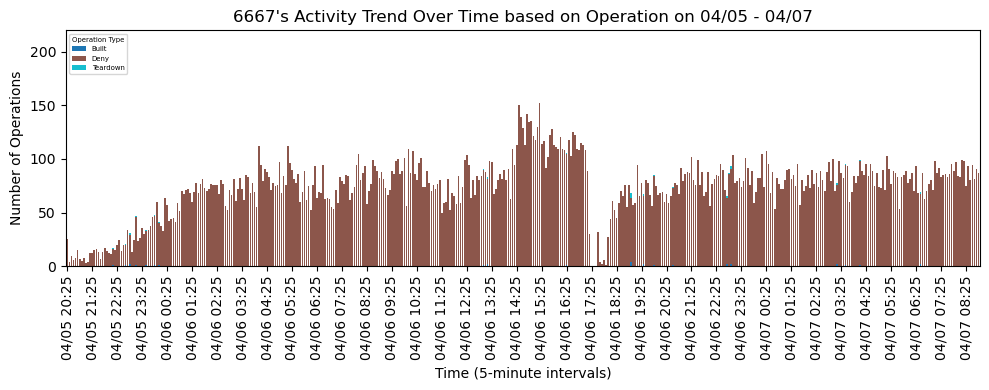

In [14]:
# Inspect individual port's activity
filter_ip_and_visualize_activity('6667')

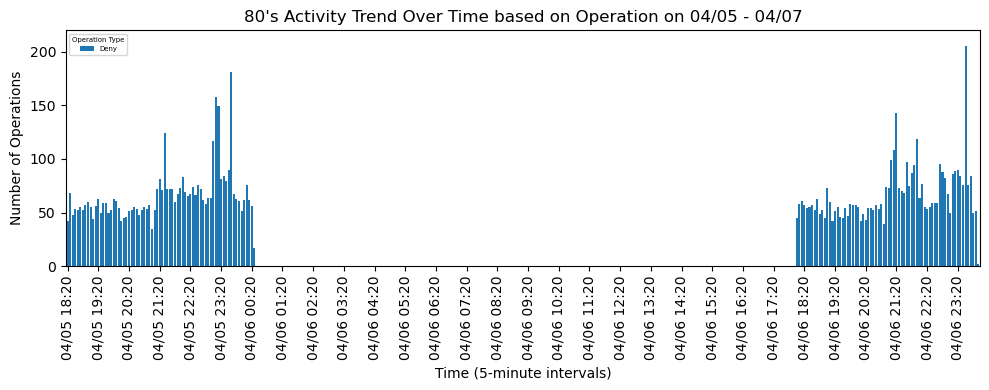

In [15]:
# Inspect individual port's activity
filter_ip_and_visualize_activity('80')

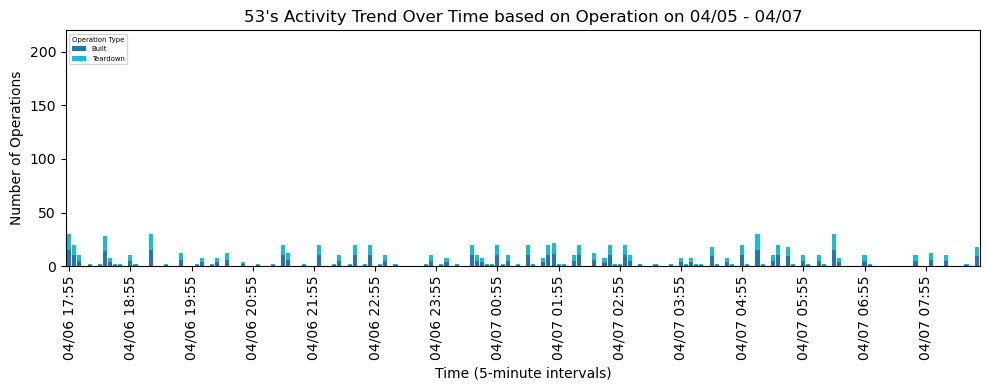

In [16]:
# Inspect individual port's activity
filter_ip_and_visualize_activity('53')